<a href="https://colab.research.google.com/github/DajanaKolarova/AI_TB_model/blob/main/TB_ResNet_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import numpy as np
from pathlib import Path
import cv2
import math
from sklearn.metrics import recall_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from collections.abc import Iterable
import matplotlib.pyplot as plt
import timm
import torchvision

In [ ]:
batch_size=30
img_size=224

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
target_class={0:"Normal",1:"Tuberculosis"}
Normal_dir=Path("/content/drive/MyDrive/TB_xray_original_dataset/Normal")
TB_dir=Path("/content/drive/MyDrive/TB_xray_original_dataset/Tuberculosis")

In [ ]:
Normal_images:list=sorted(list(map(str, list(Normal_dir.glob("*.png")))))
TB_images:list=sorted(list(map(str, list(TB_dir.glob("*.png")))))
Normal_labels:list=[0]*len(Normal_images)
TB_labels:list=[1]*len(TB_images)

In [ ]:
images=np.array(Normal_images+TB_images)
labels=np.array(Normal_labels+TB_labels)
images.shape, labels.shape

((1400,), (1400,))

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(images,labels,test_size=0.2,random_state=42)
x_valid,x_test,y_valid,y_test=train_test_split(x_valid,y_valid,test_size=0.5,random_state=42)
(x_train.shape,x_valid.shape,x_test.shape)

((1120,), (140,), (140,))

In [ ]:
def image_preprocessing(path):
    img=cv2.imread(path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    clahe=cv2.createCLAHE(clipLimit=2)
    img=clahe.apply(img)
    img=cv2.GaussianBlur(img,(5,5),0,borderType=cv2.BORDER_CONSTANT)
    img=cv2.resize(img,(img_size,img_size),interpolation=cv2.INTER_LINEAR)
    img=cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    img=np.moveaxis(img,-1,0)
    return img

In [ ]:
x_train=np.array(list(map(image_preprocessing,x_train))).astype(np.float32)
x_valid=np.array(list(map(image_preprocessing,x_valid))).astype(np.float32)
x_test=np.array(list(map(image_preprocessing,x_test))).astype(np.float32)
x_train.shape,x_valid.shape,x_test.shape

((1120, 3, 224, 224), (140, 3, 224, 224), (140, 3, 224, 224))

In [ ]:
device=("cuda" if torch.cuda.is_available() else "cpu")
x_train=torch.from_numpy(x_train).to(device)
x_valid=torch.from_numpy(x_valid).to(device)
x_test=torch.from_numpy(x_test).to(device)
y_train=torch.from_numpy(y_train).to(device)
y_valid=torch.from_numpy(y_valid).to(device)
y_test=torch.from_numpy(y_test).to(device)

In [ ]:
class StandardScaler():
    def __init__(self) -> None:
        self.mean=None
        self.std=None
    def fit(self,tensor:torch.Tensor) -> None:
        self.mean=tensor.mean((0,2,3),keepdim=True)
        self.std=tensor.std((0,2,3),keepdim=True)
    def transform(self,tensor:torch.Tensor) -> torch.Tensor:
        scaled=(tensor-self.mean)/(self.std+1e-5)
        return scaled
    def fit_transform(self,tensor:torch.Tensor) -> torch.Tensor:
        self.fit(tensor=tensor)
        scaled=self.transform(tensor=tensor)
        return scaled

In [ ]:
scaler=StandardScaler()
x_train=scaler.fit_transform(x_train)
x_test=scaler.transform(x_test)
x_valid=scaler.transform(x_valid)

In [ ]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [ ]:
train_dataset=TensorDataset(x_train,y_train)
val_dataset=TensorDataset(x_valid,y_valid)
test_dataset=TensorDataset(x_test,y_test)
train_loader=DataLoader(train_dataset,batch_size=batch_size,shuffle=False)
val_loader=DataLoader(val_dataset,batch_size=batch_size,shuffle=False)
test_loader=DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, models
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
#from medmnist import INFO, Evaluator
#from medmnist.dataset import BloodMNIST
import numpy as np
import copy
from torchvision.models import resnet18

torch: Core library for building and managing deep learning models.

torch.nn: Provides modules for creating and defining layers in neural networks.

Contains functions for operations like activation functions (F.relu) and loss functions (F.cross_entropy).

torch.optim: Includes optimizers like SGD (Stochastic Gradient Descent), Adam, etc., for training models.

DataLoader: Used to load data in batches for efficient training.

random_split: Splits datasets into training, validation, or test sets.

transforms:
Used for preprocessing and augmenting image datasets.

matplotlib.pyplot:
Used for visualizing data and plotting metrics

Generates a detailed report with precision, recall, F1-score, and support for each class.

numpy:
A fundamental library for numerical computations and matrix operations.

(1) imports the ResNet-18 model from torchvision.models. ResNet-18 is a popular deep convolutional neural network architecture that includes 18 layers and is known for its residual connections, which help mitigate the vanishing gradient problem.

(3) loads the model with pre-trained weights on the ImageNet dataset. These weights provide a strong starting point because the model has already learned to extract general image features (e.g., edges, textures, patterns).
You can fine-tune this model on your specific dataset instead of training from scratch, which is faster and requires fewer data.

(4) This retrieves the number of input features for the fully connected layer (512 for ResNet-18).
nn.Linear(model.fc.in_features, num_classes):
Replaces the original fully connected layer with a new one that outputs predictions for num_classes (your custom number of classes).
This is necessary to adapt the pre-trained ResNet model for your specific classification problem.

By replacing the fully connected layer, you ensure the model outputs predictions matching your dataset's class count.

In [ ]:
# Set seed for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)

set_seed(42)

Reproducibility ensures that the results of a machine learning experiment are consistent when the code is run multiple times.

A random seed is an initialization value that allows random number generators to produce the same sequence of numbers each time the program is run.
By setting a seed, you make experiments deterministic, which is especially important in machine learning to debug and compare results.

In [ ]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Data loading and transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

defines the data transformations that will be applied to the input dataset before it is fed into the model. These transformations are crucial for data preprocessing and augmentation, ensuring that the input data is in the correct format and normalized for better model training.

Automatically scales the pixel values from the range [0, 255] to the range [0, 1] by dividing each value by 255.
Why?

PyTorch models work with tensor inputs, so raw images must be converted to tensors.
Scaling the pixel values ensures that the data is normalized for numerical stability during training.

Why Normalize?
Standardization:
Normalizing pixel values ensures that all features (pixel intensities) have the same scale.
Prevents features with larger values from dominating others during training.
Improved Convergence:
Helps the optimizer converge faster by stabilizing gradients.
Consistent Input Distribution:
Many pre-trained models assume inputs are normalized to specific ranges (e.g., [-1, 1] or mean=0 and std=1).

Prints essential metadata about the dataset

Visualizes a random subset of images from the training dataset to understand what the data looks like.

Selects num_samples random images using np.random.choice

Converts the tensor format (Channels x Height x Width) to NumPy format (Height x Width x Channels) using np.rollaxis

Plots the images using matplotlib with their corresponding labels

Counts the number of samples per class in the training dataset

Initializes a zero array class_counts to store class-wise counts.
Iterates through all the samples in train_data and adds 1 to the respective class index (from the one-hot encoded label)

Bar Plot:
Plots the counts of samples for each class as a bar chart.
Helps identify imbalances in the dataset, e.g., if certain classes have significantly fewer samples

NOTE: updated the code to include normalization so the images are not cropped and displayed correctly

SimpleCNN inherits from torch.nn.Module, which is the base class for all neural network models in PyTorch.

The __init__ method initializes the layers of the network.

num_classes=2 is the number of output classes for classification. You have updated this to num_classes=8 in your instantiation.

Convolutional Layers

conv1: A 2D convolutional layer with 3 input channels (RGB images), 32 output channels, a kernel size of 3x3, and a stride of 1.
conv2: Another 2D convolutional layer, taking the 32-channel output of conv1 as input and producing 64 output channels.
These layers learn spatial features from the input images.

Fully Connected (Dense) Layers

fc1: A fully connected layer that takes a flattened input of size 12*12*64 (12x12 is the output size after the convolutions and pooling, and 64 is the number of channels from conv2) and outputs 128 features.
fc2: The final fully connected layer maps the 128 features to num_classes outputs.

Forward Pass

torch.relu: Applies the Rectified Linear Unit (ReLU) activation function to introduce non-linearity.
max_pool2d: Applies max pooling with a kernel size of 2, reducing the spatial dimensions by half.
torch.flatten: Flattens the tensor, making it suitable for fully connected layers. The dim=1 argument preserves the batch dimension.

In [ ]:
# Load a pre-trained ResNet model
model = models.resnet18(weights="DEFAULT")

# Modify the final layer to fit the number of classes
num_classes = 2
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

# Model summary
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 1/5, Training Loss: 0.2497, Validation Loss: 0.1117
Epoch 2/5, Training Loss: 0.0509, Validation Loss: 0.0631
Epoch 3/5, Training Loss: 0.0209, Validation Loss: 0.0440
Epoch 4/5, Training Loss: 0.0115, Validation Loss: 0.0362
Epoch 5/5, Training Loss: 0.0076, Validation Loss: 0.0309


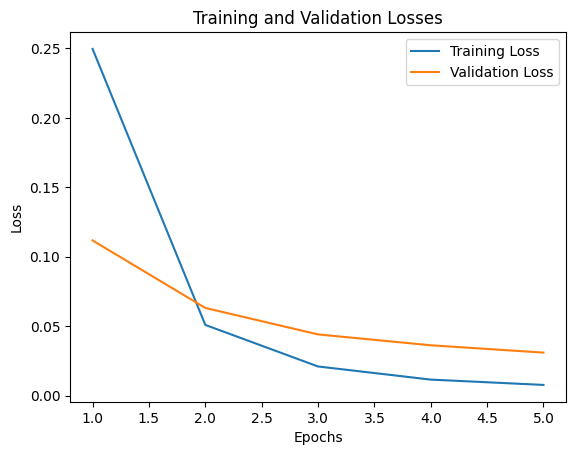

Model saved to TB_resnet.pth


In [ ]:
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training loop with tracking of losses
num_epochs = 5
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_train_loss = 0.0
    for images, labels in train_loader:
        labels = labels.view(-1)  # Flatten to [batch_size]
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    # Validation phase
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            labels = labels.view(-1)  # Flatten to [batch_size]
            images, labels = images.to(device), labels.squeeze().to(device)
            output = model(images)
            loss = criterion(output, labels)
            running_val_loss += loss.item()

    # Average losses for the epoch
    epoch_train_loss = running_train_loss / len(train_loader)
    epoch_val_loss = running_val_loss / len(val_loader)

    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}")

# Plot training and validation losses
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

# Save the model
torch.save(model.state_dict(), "TB_resnet.pth")
print("Model saved to TB_resnet.pth")

model.to(device): Moves the model to the specified device (CPU or GPU).

criterion: Defines the loss function, in this case, CrossEntropyLoss, which is commonly used for multi-class classification problems.

optimizer: Uses Stochastic Gradient Descent (SGD) to update model weights based on the gradients computed during backpropagation. Learning rate (lr) is set to 0.01.

Loops over the dataset for a specified number of epochs (num_epochs=5).

model.train(): Sets the model to training mode, enabling behaviors like dropout and batch normalization.

running_train_loss: Keeps track of the cumulative training loss for the current epoch.

labels.view(-1): Ensures the labels are in the correct shape for loss calculation.

images.to(device), labels.to(device): Moves the data to the same device as the model.

optimizer.zero_grad(): Resets gradients from the previous iteration.

model(images): Forward pass - outputs predictions for the batch of images.

criterion(output, labels): Calculates the loss between predictions (output) and true labels (labels).

loss.backward(): Backpropagates the loss to compute gradients.

optimizer.step(): Updates the model parameters using the computed gradients.
running_train_loss: Accumulates the total training loss for the epoch.

model.eval(): Sets the model to evaluation mode, disabling behaviors like dropout.

torch.no_grad(): Disables gradient
computation to save memory and improve performance during validation.

Loops through the validation dataset and calculates the validation loss

Computes the average loss for both training and validation datasets for the current epoch.
Tracks the losses in train_losses and val_losses lists for later visualization.
Prints the losses for each epoch.

Plots the training and validation losses over the epochs to visualize the model's learning process.
Key Indicators:
Decreasing training loss: The model is learning.
If validation loss decreases in tandem, the model generalizes well.
If validation loss increases while training loss decreases, overfitting might be occurring.

Saves the trained model's parameters (weights) to a file.
The model can later be reloaded for evaluation or further training using:


In [ ]:
loaded_model = copy.deepcopy(model).to(device)
loaded_model.load_state_dict(torch.load("TB_resnet.pth", weights_only=True))
loaded_model.eval()
print("Model loaded from TB_resnet.pth")

# Evaluate on test set
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.squeeze().to(device)
        output = loaded_model(images)
        _, preds = torch.max(output, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report
report = classification_report(all_labels, all_preds, target_names=[str(i) for i in range(num_classes)])
print("Classification Report:\n")
print(report)

Model loaded from TB_resnet.pth
Classification Report:

              precision    recall  f1-score   support

           0       0.99      1.00      0.99        73
           1       1.00      0.99      0.99        67

    accuracy                           0.99       140
   macro avg       0.99      0.99      0.99       140
weighted avg       0.99      0.99      0.99       140



No Gradient Calculation: torch.no_grad() ensures no gradients are calculated, saving memory and speeding up inference.

Data Iteration: The test dataset (test_loader) is iterated batch by batch.

Predictions:
output contains the model's raw predictions (logits) for each class.
torch.max(output, 1) gives the class index (preds) with the highest predicted probability for each sample in the batch.
The predictions (preds) and ground truth (labels) are stored in lists for further evaluation. A deep copy of the existing model is created and moved to the appropriate device (CPU or GPU).
The pre-trained model's state is loaded from the saved .pth file.


The eval() method is called, putting the model in evaluation mode, which:
Disables dropout layers (if any).
Ensures batch normalization layers use pre-computed statistics.


Classification Report:
classification_report (from sklearn.metrics) calculates metrics like precision, recall, F1-score, and support for each class.
The target_names argument maps class indices to their labels (or names). Here, it uses string representations of class indices.

Precision: Fraction of true positive predictions out of all positive predictions for each class.

Recall: Fraction of true positive predictions out of all actual positives for each class.

F1-score: Harmonic mean of precision and recall.

Support: Number of samples for each class in the test dataset.
